In [2]:
print("Namaha Shivaya")

Namaha Shivaya


In [3]:
import os
import random
from pathlib import Path
import numpy as np
import torch

# ========================
# DATASET ROOT (LOCAL)
# ========================
DATASET_ROOT = r"C:\\Users\\vuppa\\OneDrive\\Desktop\\Chili Leaf Disease Augmented Dataset"

CLASSES = [
    "Bacterial Spot",
    "Cercospora Leaf Spot",
    "Curl Virus",
    "Healthy Leaf",
    "Nutrition Deficiency",
    "White spot",
]
NUM_CLASSES = len(CLASSES)

# ========================
# PATHS (ConvNeXt only)
# ========================
SPLIT_ROOT = Path("./chili_split_convnext")
SPLIT_ROOT.mkdir(parents=True, exist_ok=True)

CHECKPOINT_DIR = Path("./convnext_checkpoints")
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

# ========================
# REPRODUCIBILITY
# ========================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# ========================
# DEVICE
# ========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

print("Dataset folders:", os.listdir(DATASET_ROOT))


Device: cuda
Dataset folders: ['Bacterial Spot', 'Cercospora Leaf Spot', 'Curl Virus', 'Healthy Leaf', 'Nutrition Deficiency', 'White spot']


In [8]:
import shutil
from sklearn.model_selection import train_test_split

for phase in ["train", "val", "test"]:
    for cls in CLASSES:
        os.makedirs(SPLIT_ROOT / phase / cls, exist_ok=True)

for cls in CLASSES:
    img_dir = os.path.join(DATASET_ROOT, cls)
    images = os.listdir(img_dir)

    train_imgs, temp_imgs = train_test_split(
        images, test_size=0.30, random_state=SEED, shuffle=True
    )
    val_imgs, test_imgs = train_test_split(
        temp_imgs, test_size=0.50, random_state=SEED, shuffle=True
    )

    for img in train_imgs:
        shutil.copy(os.path.join(img_dir, img), SPLIT_ROOT / "train" / cls)
    for img in val_imgs:
        shutil.copy(os.path.join(img_dir, img), SPLIT_ROOT / "val" / cls)
    for img in test_imgs:
        shutil.copy(os.path.join(img_dir, img), SPLIT_ROOT / "test" / cls)

print("✔ Dataset split completed (70 / 15 / 15)")
print("Split path:", SPLIT_ROOT)


✔ Dataset split completed (70 / 15 / 15)
Split path: chili_split_convnext


In [9]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

IMG_SIZE = 224
BATCH_SIZE = 32

# -------- Transforms --------
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(8),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

# -------- Datasets --------
train_dataset = ImageFolder(SPLIT_ROOT / "train", transform=train_transform)
val_dataset   = ImageFolder(SPLIT_ROOT / "val",   transform=val_test_transform)
test_dataset  = ImageFolder(SPLIT_ROOT / "test",  transform=val_test_transform)

# -------- Dataloaders --------
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print("✔ Dataloaders Ready")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches  : {len(val_loader)}")
print(f"Test batches : {len(test_loader)}")


✔ Dataloaders Ready
Train batches: 263
Val batches  : 57
Test batches : 57


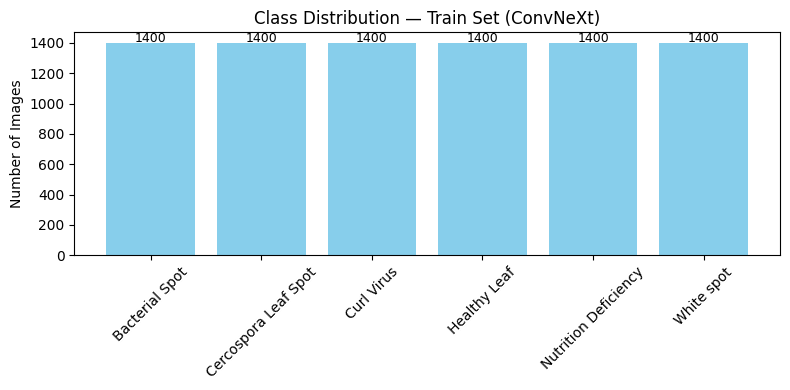

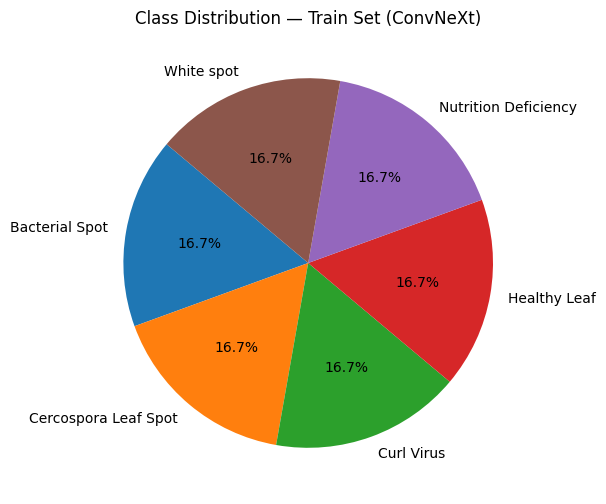

In [14]:
import os
import matplotlib.pyplot as plt

# Train directory
train_dir = SPLIT_ROOT / "train"

# Count images per class
train_counts = {
    cls: len(os.listdir(train_dir / cls))
    for cls in CLASSES
}

# Sort for clean visualization
train_counts = dict(sorted(train_counts.items()))

# -------- Bar Plot --------
plt.figure(figsize=(8,4))
bars = plt.bar(train_counts.keys(), train_counts.values(), color="skyblue")
plt.title("Class Distribution — Train Set (ConvNeXt)")
plt.xticks(rotation=45)
plt.ylabel("Number of Images")

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 5,
        str(height),
        ha="center",
        fontsize=9
    )

plt.tight_layout()
plt.show()

# -------- Pie Chart --------
plt.figure(figsize=(6,6))
plt.pie(
    train_counts.values(),
    labels=train_counts.keys(),
    autopct="%1.1f%%",
    startangle=140
)
plt.title("Class Distribution — Train Set (ConvNeXt)")
plt.show()


In [18]:
# =========================================================
# PHASE-2 — STEP-1: Define ConvNeXt-Tiny Model (Stage-1)
# Feature Extraction (Freeze Backbone)
# =========================================================

import torch
import torch.nn as nn
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights

NUM_CLASSES = len(CLASSES)

# Load pretrained ConvNeXt-Tiny
model = convnext_tiny(weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1)

# Freeze backbone
for param in model.parameters():
    param.requires_grad = False

# ConvNeXt uses model.classifier[-1] as Linear layer
in_features = model.classifier[-1].in_features

# Replace classifier (MATCHES training & evaluation)
model.classifier = nn.Sequential(
    nn.Flatten(),                # IMPORTANT for ConvNeXt
    nn.Linear(in_features, NUM_CLASSES)
)

model = model.to(device)

print("ConvNeXt-Tiny initialized for Stage-1 (feature extraction only).")
print(
    "Trainable parameters:",
    sum(p.numel() for p in model.parameters() if p.requires_grad)
)


ConvNeXt-Tiny initialized for Stage-1 (feature extraction only).
Trainable parameters: 4614


In [20]:
# =========================================================
# PHASE-2 — STEP-2: Stage-1 Training (ConvNeXt Baseline)
# (VS Code / Local GPU compatible)
# =========================================================

import os
import torch
import torch.nn as nn
import torch.optim as optim
import time

# ---------- Create checkpoint directory ----------
CHECKPOINT_DIR = r"C:\Users\vuppa\OneDrive\Desktop\convnext_checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

STAGE1_CKPT_PATH = os.path.join(
    CHECKPOINT_DIR,
    "convnext_tiny_stage1_best.pth"
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-3
)

EPOCHS_STAGE1 = 5
best_val_acc_stage1 = 0.0
start_time = time.time()

for epoch in range(1, EPOCHS_STAGE1 + 1):
    # -------------------- Training --------------------
    model.train()
    train_correct = 0
    train_total = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = outputs.argmax(1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    train_acc = train_correct / train_total

    # -------------------- Validation --------------------
    model.eval()
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs).argmax(1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total

    print(
        f"Stage-1 Epoch {epoch}/{EPOCHS_STAGE1} | "
        f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}"
    )

    if val_acc > best_val_acc_stage1:
        best_val_acc_stage1 = val_acc
        torch.save(model.state_dict(), STAGE1_CKPT_PATH)
        print("→ Best model updated and saved.")

elapsed = (time.time() - start_time) / 60
print(f"\nStage-1 training complete in {elapsed:.2f} minutes.")
print(f"Best Stage-1 Validation Accuracy: {best_val_acc_stage1:.4f}")
print(f"Checkpoint saved → {STAGE1_CKPT_PATH}")


Stage-1 Epoch 1/5 | Train Acc: 0.9421 | Val Acc: 0.9561
→ Best model updated and saved.
Stage-1 Epoch 2/5 | Train Acc: 0.9556 | Val Acc: 0.9672
→ Best model updated and saved.
Stage-1 Epoch 3/5 | Train Acc: 0.9635 | Val Acc: 0.9700
→ Best model updated and saved.
Stage-1 Epoch 4/5 | Train Acc: 0.9714 | Val Acc: 0.9717
→ Best model updated and saved.
Stage-1 Epoch 5/5 | Train Acc: 0.9750 | Val Acc: 0.9728
→ Best model updated and saved.

Stage-1 training complete in 5.15 minutes.
Best Stage-1 Validation Accuracy: 0.9728
Checkpoint saved → C:\Users\vuppa\OneDrive\Desktop\convnext_checkpoints\convnext_tiny_stage1_best.pth


In [22]:
# =========================================================
# PHASE-2 — STEP-3: Stage-2 Fine-Tuning (ConvNeXt-Tiny)
# =========================================================

import torch
import torch.nn as nn
import torch.optim as optim
import time

# ---------- Paths ----------
CHECKPOINT_DIR = r"C:\Users\vuppa\OneDrive\Desktop\convnext_checkpoints"
STAGE1_CKPT = os.path.join(CHECKPOINT_DIR, "convnext_tiny_stage1_best.pth")
STAGE2_CKPT = os.path.join(CHECKPOINT_DIR, "convnext_tiny_stage2_best.pth")

# ---------- Load Stage-1 weights ----------
model.load_state_dict(torch.load(STAGE1_CKPT, map_location=device))
print(f"Loaded Stage-1 checkpoint → {STAGE1_CKPT}")

# ---------- Unfreeze entire model ----------
for param in model.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

EPOCHS_STAGE2 = 10
best_val_acc_stage2 = 0.0
start_time = time.time()

print("\nStarting Stage-2 Fine-Tuning...\n")

for epoch in range(1, EPOCHS_STAGE2 + 1):
    # -------------------- Training --------------------
    model.train()
    train_correct = 0
    train_total = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = outputs.argmax(1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    train_acc = train_correct / train_total

    # -------------------- Validation --------------------
    model.eval()
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs).argmax(1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total

    print(
        f"Stage-2 Epoch {epoch}/{EPOCHS_STAGE2} | "
        f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}"
    )

    if val_acc > best_val_acc_stage2:
        best_val_acc_stage2 = val_acc
        torch.save(model.state_dict(), STAGE2_CKPT)
        print("→ Best model updated and saved.")

elapsed = (time.time() - start_time) / 60
print(f"\nStage-2 Fine-Tuning complete in {elapsed:.2f} minutes.")
print(f"Best Stage-2 Validation Accuracy: {best_val_acc_stage2:.4f}")
print(f"Final checkpoint saved → {STAGE2_CKPT}")


Loaded Stage-1 checkpoint → C:\Users\vuppa\OneDrive\Desktop\convnext_checkpoints\convnext_tiny_stage1_best.pth

Starting Stage-2 Fine-Tuning...

Stage-2 Epoch 1/10 | Train Acc: 0.9862 | Val Acc: 0.9944
→ Best model updated and saved.
Stage-2 Epoch 2/10 | Train Acc: 0.9930 | Val Acc: 0.9961
→ Best model updated and saved.
Stage-2 Epoch 3/10 | Train Acc: 0.9927 | Val Acc: 0.9961
Stage-2 Epoch 4/10 | Train Acc: 0.9920 | Val Acc: 0.9878
Stage-2 Epoch 5/10 | Train Acc: 0.9936 | Val Acc: 0.9950
Stage-2 Epoch 6/10 | Train Acc: 0.9931 | Val Acc: 0.9961
Stage-2 Epoch 7/10 | Train Acc: 0.9926 | Val Acc: 0.9939
Stage-2 Epoch 8/10 | Train Acc: 0.9926 | Val Acc: 0.9961
Stage-2 Epoch 9/10 | Train Acc: 0.9927 | Val Acc: 0.9961
Stage-2 Epoch 10/10 | Train Acc: 0.9939 | Val Acc: 0.9922

Stage-2 Fine-Tuning complete in 19.62 minutes.
Best Stage-2 Validation Accuracy: 0.9961
Final checkpoint saved → C:\Users\vuppa\OneDrive\Desktop\convnext_checkpoints\convnext_tiny_stage2_best.pth


Loaded ConvNeXt-Tiny Weights → C:\Users\vuppa\OneDrive\Desktop\convnext_checkpoints\convnext_tiny_stage2_best.pth

Test Accuracy (ConvNeXt-Tiny): 99.33%

Classification Report:

                      precision    recall  f1-score   support

      Bacterial Spot       0.97      0.99      0.98       300
Cercospora Leaf Spot       0.99      0.97      0.98       300
          Curl Virus       1.00      1.00      1.00       300
        Healthy Leaf       1.00      1.00      1.00       300
Nutrition Deficiency       1.00      1.00      1.00       300
          White spot       1.00      1.00      1.00       300

            accuracy                           0.99      1800
           macro avg       0.99      0.99      0.99      1800
        weighted avg       0.99      0.99      0.99      1800



,precision,recall,f1-score,support
Bacterial Spot,0.967532,0.993333,0.980263,300.000000
Cercospora Leaf Spot,0.993151,0.966667,0.979730,300.000000
Curl Virus,1.000000,1.000000,1.000000,300.000000
Healthy Leaf,1.000000,1.000000,1.000000,300.000000
Nutrition Deficiency,1.000000,1.000000,1.000000,300.000000
White spot,1.000000,1.000000,1.000000,300.000000
accuracy,0.993333,0.993333,0.993333,0.993333
macro avg,0.993447,0.993333,0.993332,1800.000000
weighted avg,0.993447,0.993333,0.993332,1800.000000


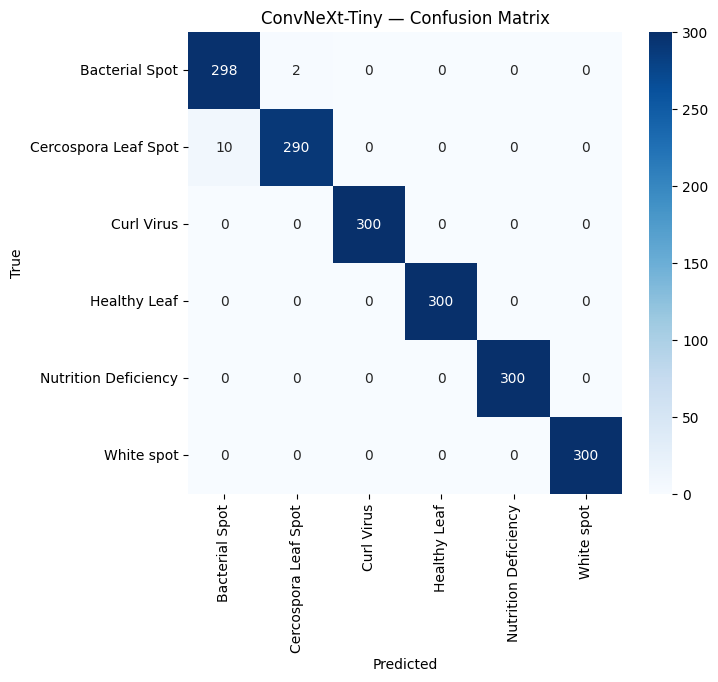

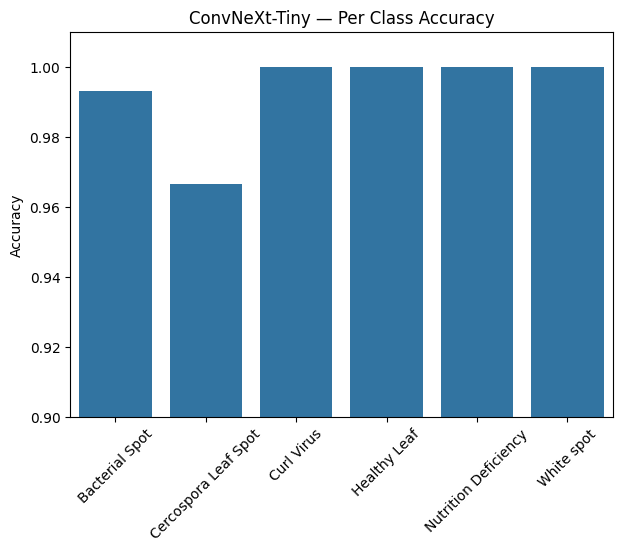

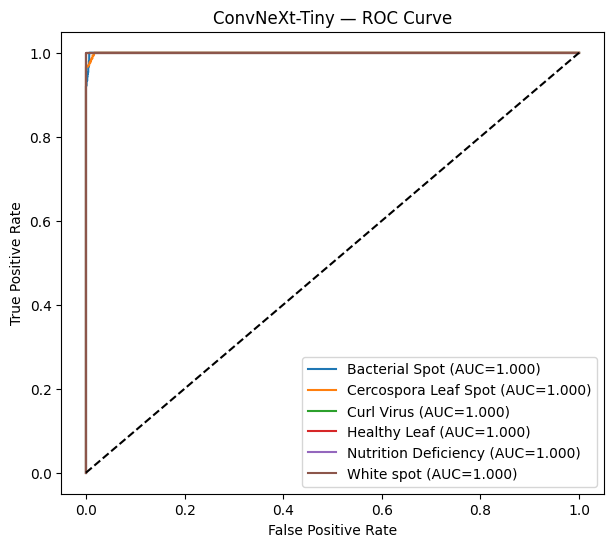

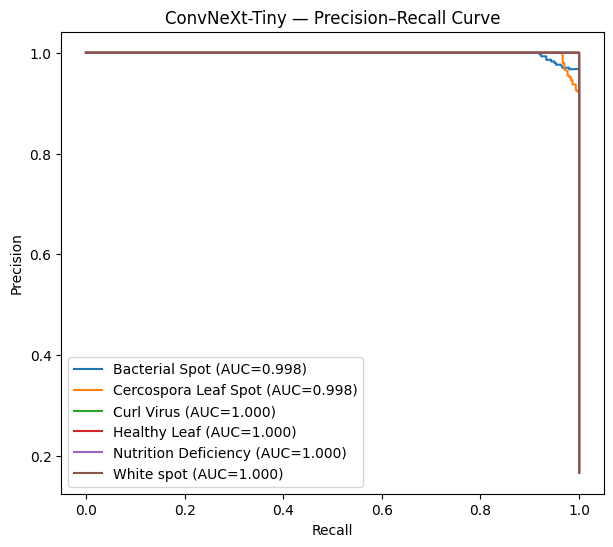

----- Final Summary Metrics -----
Test Accuracy     : 99.33%
Macro F1 Score    : 0.9933
Weighted F1 Score : 0.9933
Macro ROC-AUC     : 0.9999
Macro PR-AUC      : 0.9994
---------------------------------



In [23]:
# =========================================================
# PHASE-3 — TEST EVALUATION (ConvNeXt-Tiny)
# =========================================================

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    f1_score
)

from torchvision import models
import torch.nn as nn

# ---------------- Build model EXACTLY like training ----------------
model = models.convnext_tiny(weights=None)

# ConvNeXt classifier structure MUST match training
in_features = model.classifier[2].in_features
model.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features, NUM_CLASSES)
)

model = model.to(device)

# ---------------- Load Stage-2 Checkpoint ----------------
CKPT_PATH = r"C:\Users\vuppa\OneDrive\Desktop\convnext_checkpoints\convnext_tiny_stage2_best.pth"
state_dict = torch.load(CKPT_PATH, map_location=device)
model.load_state_dict(state_dict)
model.eval()

print(f"Loaded ConvNeXt-Tiny Weights → {CKPT_PATH}")

# ---------------- Start Evaluation ----------------
all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_preds  = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs  = np.array(all_probs)

# ---------------- Accuracy ----------------
test_acc = (all_preds == all_labels).mean() * 100
print(f"\nTest Accuracy (ConvNeXt-Tiny): {test_acc:.2f}%\n")

# ---------------- Classification Report ----------------
print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=CLASSES))

df_report = pd.DataFrame(
    classification_report(
        all_labels, all_preds,
        target_names=CLASSES,
        output_dict=True
    )
).transpose()
display(df_report)

# ---------------- Confusion Matrix ----------------
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(7,6))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=CLASSES, yticklabels=CLASSES
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("ConvNeXt-Tiny — Confusion Matrix")
plt.show()

# ---------------- Per-class Accuracy ----------------
class_acc = cm.diagonal() / cm.sum(axis=1)

plt.figure(figsize=(7,5))
sns.barplot(x=CLASSES, y=class_acc)
plt.ylim(0.90, 1.01)
plt.title("ConvNeXt-Tiny — Per Class Accuracy")
plt.xticks(rotation=45)
plt.ylabel("Accuracy")
plt.show()

# ---------------- ROC Curve ----------------
plt.figure(figsize=(7,6))
roc_auc_list = []

for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(all_labels == i, all_probs[:, i])
    auc_score = auc(fpr, tpr)
    roc_auc_list.append(auc_score)
    plt.plot(fpr, tpr, label=f"{CLASSES[i]} (AUC={auc_score:.3f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ConvNeXt-Tiny — ROC Curve")
plt.legend()
plt.show()

# ---------------- Precision–Recall Curve ----------------
plt.figure(figsize=(7,6))
pr_auc_list = []

for i in range(NUM_CLASSES):
    precision, recall, _ = precision_recall_curve(
        all_labels == i, all_probs[:, i]
    )
    pr_auc = auc(recall, precision)
    pr_auc_list.append(pr_auc)
    plt.plot(recall, precision, label=f"{CLASSES[i]} (AUC={pr_auc:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("ConvNeXt-Tiny — Precision–Recall Curve")
plt.legend()
plt.show()

# ---------------- Summary Metrics ----------------
macro_f1      = f1_score(all_labels, all_preds, average="macro")
weighted_f1   = f1_score(all_labels, all_preds, average="weighted")
roc_auc_macro = np.mean(roc_auc_list)
pr_auc_macro  = np.mean(pr_auc_list)

print("----- Final Summary Metrics -----")
print(f"Test Accuracy     : {test_acc:.2f}%")
print(f"Macro F1 Score    : {macro_f1:.4f}")
print(f"Weighted F1 Score : {weighted_f1:.4f}")
print(f"Macro ROC-AUC     : {roc_auc_macro:.4f}")
print(f"Macro PR-AUC      : {pr_auc_macro:.4f}")
print("---------------------------------\n")


In [25]:
# =========================================================
# PHASE-3 — HYPERPARAMETER TUNING (ConvNeXt-Tiny)
# Stage-1 ONLY — Same workflow as previous models
# =========================================================

from torchvision import models
import torch.nn as nn
import torch.optim as optim
from copy import deepcopy
import torch

# ---------------- HPT Configurations ----------------
HPT_CONFIGS = [
    {"lr": 1e-3, "dropout": 0.3, "fc_units": 256},
    {"lr": 1e-3, "dropout": 0.4, "fc_units": 256},
    {"lr": 1e-3, "dropout": 0.5, "fc_units": 512},
    {"lr": 5e-4, "dropout": 0.3, "fc_units": 256},
    {"lr": 5e-4, "dropout": 0.4, "fc_units": 512},
    {"lr": 5e-4, "dropout": 0.5, "fc_units": 512},
    {"lr": 3e-4, "dropout": 0.3, "fc_units": 384},
    {"lr": 3e-4, "dropout": 0.4, "fc_units": 512},
    {"lr": 3e-4, "dropout": 0.5, "fc_units": 640},
    {"lr": 1e-4, "dropout": 0.3, "fc_units": 512},
    {"lr": 1e-4, "dropout": 0.4, "fc_units": 640},
    {"lr": 1e-4, "dropout": 0.5, "fc_units": 768},
]

print("HPT configurations loaded:", len(HPT_CONFIGS))
print("\n===== Running 12 HPT Trials for ConvNeXt-Tiny =====\n")

criterion = nn.CrossEntropyLoss()

results_hpt = []
best_cfg_hpt = None
best_val_acc_hpt = 0.0

# ---------------- HPT Loop ----------------
for idx, cfg in enumerate(HPT_CONFIGS, 1):
    lr = cfg["lr"]
    dropout = cfg["dropout"]
    units = cfg["fc_units"]

    print(f"\n===== HPT TRIAL {idx}/12 | lr={lr} dropout={dropout} units={units} =====")

    # -------- Build ConvNeXt-Tiny (Stage-1) --------
    model_hpt = models.convnext_tiny(weights="IMAGENET1K_V1")

    # Freeze backbone
    for p in model_hpt.parameters():
        p.requires_grad = False

    in_features = model_hpt.classifier[2].in_features

    # EXACT SAME classifier logic as other models
    model_hpt.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features, units),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(units, NUM_CLASSES)
    )

    model_hpt = model_hpt.to(device)
    optimizer = optim.Adam(model_hpt.classifier.parameters(), lr=lr)

    # -------- Stage-1 Training Only --------
    EPOCHS_STAGE1 = 4
    best_val_trial = 0.0

    for epoch in range(1, EPOCHS_STAGE1 + 1):
        model_hpt.train()
        train_correct = 0
        train_total = 0

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model_hpt(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            preds = outputs.argmax(1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)

        train_acc = train_correct / train_total

        # Validation
        model_hpt.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                preds = model_hpt(imgs).argmax(1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total
        print(
            f"  Stage-1 Epoch {epoch}/{EPOCHS_STAGE1} | "
            f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}"
        )

        best_val_trial = max(best_val_trial, val_acc)

    results_hpt.append({
        "lr": lr,
        "dropout": dropout,
        "fc_units": units,
        "val_acc": best_val_trial
    })

    if best_val_trial > best_val_acc_hpt:
        best_val_acc_hpt = best_val_trial
        best_cfg_hpt = deepcopy(cfg)

    torch.cuda.empty_cache()

# ---------------- Results Summary ----------------
results_hpt_sorted = sorted(results_hpt, key=lambda x: x["val_acc"], reverse=True)

print("\n===== HPT RESULTS (BEST → WORST) — ConvNeXt-Tiny =====")
for r in results_hpt_sorted:
    print(r)

print("\n===== BEST CONFIGURATION — Stage-1 HPT =====")
print(best_cfg_hpt)
print(f"Best Stage-1 Validation Accuracy: {best_val_acc_hpt:.4f}")

# Save best config info (for reference)
HPT_STAGE1_PATH = r"C:\Users\vuppa\OneDrive\Desktop\convnext_checkpoints\convnext_tiny_hpt_stage1_best.pth"
torch.save(best_cfg_hpt, HPT_STAGE1_PATH)
print(f"\nCheckpoint saved → {HPT_STAGE1_PATH}")


HPT configurations loaded: 12

===== Running 12 HPT Trials for ConvNeXt-Tiny =====


===== HPT TRIAL 1/12 | lr=0.001 dropout=0.3 units=256 =====
  Stage-1 Epoch 1/4 | Train Acc: 0.9074 | Val Acc: 0.9789
  Stage-1 Epoch 2/4 | Train Acc: 0.9774 | Val Acc: 0.9872
  Stage-1 Epoch 3/4 | Train Acc: 0.9845 | Val Acc: 0.9906
  Stage-1 Epoch 4/4 | Train Acc: 0.9877 | Val Acc: 0.9906

===== HPT TRIAL 2/12 | lr=0.001 dropout=0.4 units=256 =====
  Stage-1 Epoch 1/4 | Train Acc: 0.8956 | Val Acc: 0.9750
  Stage-1 Epoch 2/4 | Train Acc: 0.9755 | Val Acc: 0.9878
  Stage-1 Epoch 3/4 | Train Acc: 0.9821 | Val Acc: 0.9878
  Stage-1 Epoch 4/4 | Train Acc: 0.9874 | Val Acc: 0.9911

===== HPT TRIAL 3/12 | lr=0.001 dropout=0.5 units=512 =====
  Stage-1 Epoch 1/4 | Train Acc: 0.9058 | Val Acc: 0.9817
  Stage-1 Epoch 2/4 | Train Acc: 0.9781 | Val Acc: 0.9839
  Stage-1 Epoch 3/4 | Train Acc: 0.9854 | Val Acc: 0.9822
  Stage-1 Epoch 4/4 | Train Acc: 0.9883 | Val Acc: 0.9917

===== HPT TRIAL 4/12 | lr=0.0005 dro

In [29]:
# =========================================================
# PHASE-2 — STEP-3: Stage-2 Fine-Tuning (ConvNeXt-Tiny) — robust load & train cell
# - This cell safely loads a checkpoint (prefers HPT stage1 if present, else baseline stage2)
# - It strips any classifier keys from the checkpoint before loading (avoids shape/key mismatches)
# - Unfreezes the whole model and fine-tunes for EPOCHS_STAGE2
#
# REQUIREMENTS / ASSUMPTIONS:
# - `model` is already defined as ConvNeXt-Tiny and its classifier matches the classifier used during HPT.
# - `train_loader` and `val_loader` are available.
# - `device` is set (cuda or cpu).
# - Update the PATH variables below if your folders differ.
# =========================================================

import os
import time
import torch
import torch.nn as nn
import torch.optim as optim

# ---------- Paths (update if needed) ----------
CHECKPOINT_DIR = r"C:\Users\vuppa\OneDrive\Desktop\convnext_checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# candidate checkpoints (preference order)
STAGE1_HPT_CKPT   = os.path.join(CHECKPOINT_DIR, "convnext_tiny_hpt_stage1_best.pth")   # HPT Stage-1 (may be present)
BASELINE_STAGE2_CKPT = os.path.join(CHECKPOINT_DIR, "convnext_tiny_stage2_best.pth")     # baseline Stage-2 backbone
STAGE2_CKPT       = os.path.join(CHECKPOINT_DIR, "convnext_tiny_stage2_finetuned.pth")   # where to save final

# ---------- Helper: extract a state_dict (handles a few save formats) ----------
def extract_state_dict(ckpt):
    """
    Accepts whatever torch.load returned. Returns a dict of parameter tensors suitable for model.load_state_dict
    or None if the loaded object doesn't look like a model state dict.
    """
    if isinstance(ckpt, dict):
        # common wrappers
        for k in ("state_dict", "model_state", "model_state_dict"):
            if k in ckpt and isinstance(ckpt[k], dict):
                return ckpt[k]
        # if values are tensors, assume it's already a state_dict
        # (skip non-tensor values like lr/dropout config)
        tensor_values = [isinstance(v, torch.Tensor) for v in ckpt.values()]
        if any(tensor_values) and all(tv or (not tv and isinstance(list(ckpt.values())[0], torch.Tensor)) for tv in tensor_values):
            # somewhat permissive: return only tensor entries
            filtered = {k: v for k, v in ckpt.items() if isinstance(v, torch.Tensor)}
            return filtered if filtered else None
        # if ckpt looks like a small config (lr/dropout), return None
        return None
    # else not a dict
    return None

# ---------- Choose which checkpoint to load ----------
candidate = None
if os.path.exists(STAGE1_HPT_CKPT):
    candidate = STAGE1_HPT_CKPT
elif os.path.exists(BASELINE_STAGE2_CKPT):
    candidate = BASELINE_STAGE2_CKPT
else:
    raise FileNotFoundError(
        "No suitable checkpoint found. Place convnext checkpoint in CHECKPOINT_DIR "
        f"({CHECKPOINT_DIR}) as either 'convnext_tiny_hpt_stage1_best.pth' or 'convnext_tiny_stage2_best.pth'."
    )

print(f"Attempting to load checkpoint → {candidate}")

raw = torch.load(candidate, map_location=device)
state_dict = extract_state_dict(raw)

# If the loaded file wasn't a state_dict (e.g., you saved a small config dict by mistake),
# try the other fallback (if available) before failing.
if state_dict is None:
    # try the other candidate if exists and not same
    other = BASELINE_STAGE2_CKPT if candidate == STAGE1_HPT_CKPT else STAGE1_HPT_CKPT
    if other and os.path.exists(other):
        print(f"Loaded file '{candidate}' doesn't appear to contain model weights. Trying fallback: {other}")
        raw = torch.load(other, map_location=device)
        state_dict = extract_state_dict(raw)

if state_dict is None:
    raise RuntimeError(
        "Loaded checkpoint does not contain a usable state_dict. "
        "You may have accidentally saved a config dict (lr/dropout) instead of model.state_dict()."
    )

# ---------- Remove classifier keys to avoid shape/key mismatches ----------
keys_to_remove = [k for k in state_dict.keys() if k.startswith("classifier.") or k.startswith("head.") or k.startswith("fc.")]
if keys_to_remove:
    for k in keys_to_remove:
        del state_dict[k]
    print(f"Removed classifier keys from checkpoint: {len(keys_to_remove)} entries deleted.")

# Also remove any non-tensor entries (just in case)
non_tensor_keys = [k for k, v in list(state_dict.items()) if not isinstance(v, torch.Tensor)]
for k in non_tensor_keys:
    del state_dict[k]

# ---------- Load backbone weights (non-strict) ----------
# model must be defined already and on device
model = model.to(device)
load_result = model.load_state_dict(state_dict, strict=False)  # will ignore missing classifier keys
print("Loaded checkpoint into model (backbone).")
if load_result.missing_keys:
    print("Missing keys after load (expected for classifier):", load_result.missing_keys[:10])
if load_result.unexpected_keys:
    print("Unexpected keys after load (should be none):", load_result.unexpected_keys[:10])

# ---------- Unfreeze entire model ----------
for p in model.parameters():
    p.requires_grad = True

# ---------- Training setup ----------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)   # lower LR for fine-tuning
EPOCHS_STAGE2 = 10
best_val_acc_stage2 = 0.0
start_time = time.time()

print("\nStarting Stage-2 Fine-Tuning...\n")

for epoch in range(1, EPOCHS_STAGE2 + 1):
    model.train()
    train_correct = 0
    train_total = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = outputs.argmax(1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    train_acc = train_correct / train_total if train_total > 0 else 0.0

    # ---------- Validation ----------
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs).argmax(1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total if val_total > 0 else 0.0

    print(f"Stage-2 Epoch {epoch}/{EPOCHS_STAGE2} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc_stage2:
        best_val_acc_stage2 = val_acc
        torch.save(model.state_dict(), STAGE2_CKPT)
        print("→ Best model updated and saved.")

elapsed = (time.time() - start_time) / 60
print(f"\nStage-2 Fine-Tuning complete in {elapsed:.2f} minutes.")
print(f"Best Stage-2 Validation Accuracy: {best_val_acc_stage2:.4f}")
print(f"Final checkpoint saved → {STAGE2_CKPT}")


Attempting to load checkpoint → C:\Users\vuppa\OneDrive\Desktop\convnext_checkpoints\convnext_tiny_hpt_stage1_best.pth
Loaded file 'C:\Users\vuppa\OneDrive\Desktop\convnext_checkpoints\convnext_tiny_hpt_stage1_best.pth' doesn't appear to contain model weights. Trying fallback: C:\Users\vuppa\OneDrive\Desktop\convnext_checkpoints\convnext_tiny_stage2_best.pth
Removed classifier keys from checkpoint: 2 entries deleted.
Loaded checkpoint into model (backbone).
Missing keys after load (expected for classifier): ['classifier.1.weight', 'classifier.1.bias', 'classifier.4.weight', 'classifier.4.bias']

Starting Stage-2 Fine-Tuning...

Stage-2 Epoch 1/10 | Train Acc: 0.9685 | Val Acc: 0.9944
→ Best model updated and saved.
Stage-2 Epoch 2/10 | Train Acc: 0.9927 | Val Acc: 0.9956
→ Best model updated and saved.
Stage-2 Epoch 3/10 | Train Acc: 0.9913 | Val Acc: 0.9944
Stage-2 Epoch 4/10 | Train Acc: 0.9944 | Val Acc: 0.9961
→ Best model updated and saved.
Stage-2 Epoch 5/10 | Train Acc: 0.9937 |

Loaded ConvNeXt-Tiny HPT Weights → C:\Users\vuppa\OneDrive\Desktop\convnext_checkpoints\convnext_tiny_stage2_finetuned.pth

HPT Test Accuracy (ConvNeXt-Tiny): 99.44%

Classification Report:

                      precision    recall  f1-score   support

      Bacterial Spot       0.97      1.00      0.98       300
Cercospora Leaf Spot       1.00      0.97      0.98       300
          Curl Virus       1.00      1.00      1.00       300
        Healthy Leaf       1.00      1.00      1.00       300
Nutrition Deficiency       1.00      1.00      1.00       300
          White spot       1.00      1.00      1.00       300

            accuracy                           0.99      1800
           macro avg       0.99      0.99      0.99      1800
        weighted avg       0.99      0.99      0.99      1800



,precision,recall,f1-score,support
Bacterial Spot,0.967742,1.000000,0.983607,300.000000
Cercospora Leaf Spot,1.000000,0.966667,0.983051,300.000000
Curl Virus,1.000000,1.000000,1.000000,300.000000
Healthy Leaf,1.000000,1.000000,1.000000,300.000000
Nutrition Deficiency,1.000000,1.000000,1.000000,300.000000
White spot,1.000000,1.000000,1.000000,300.000000
accuracy,0.994444,0.994444,0.994444,0.994444
macro avg,0.994624,0.994444,0.994443,1800.000000
weighted avg,0.994624,0.994444,0.994443,1800.000000


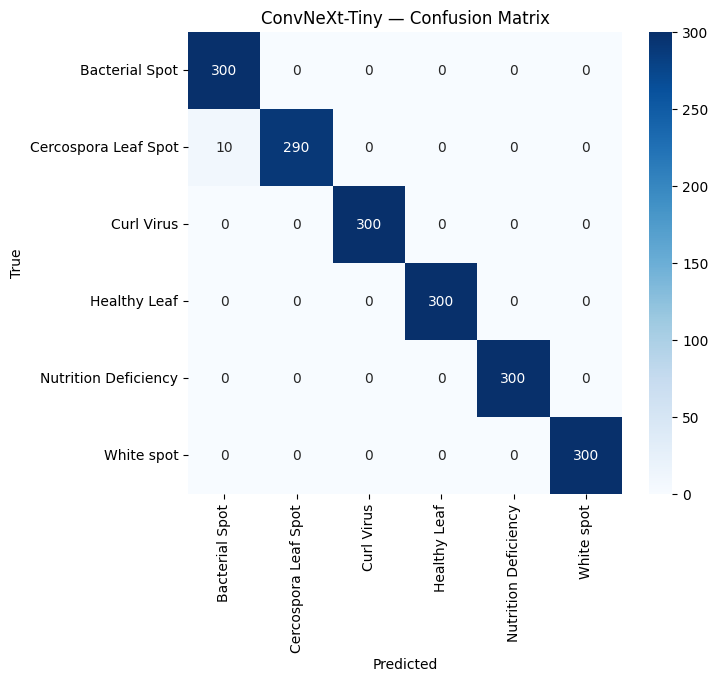

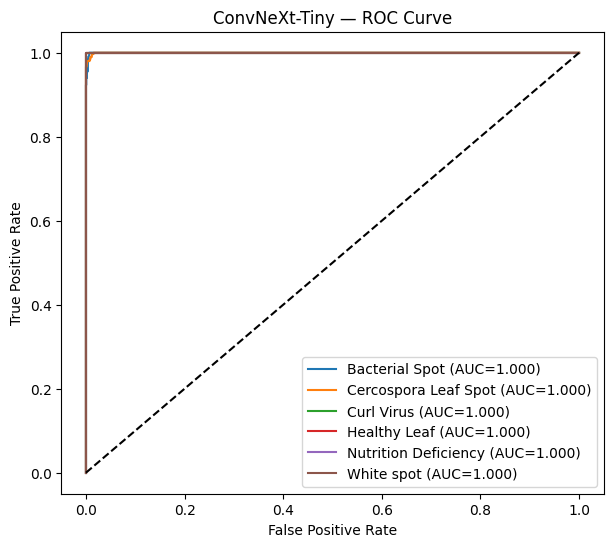

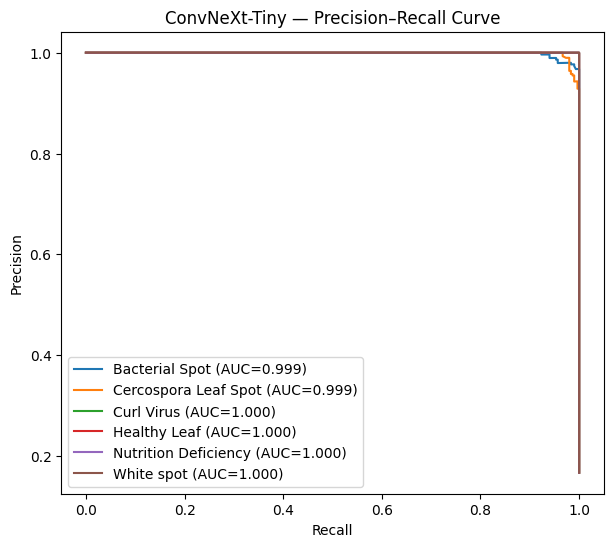

----- Final Summary Metrics -----
Test Accuracy     : 99.44%
Macro F1 Score    : 0.9944
Weighted F1 Score : 0.9944
Macro ROC-AUC     : 0.9999
Macro PR-AUC      : 0.9996
---------------------------------


In [32]:
# =========================================================
# PHASE-3 — TEST EVALUATION (ConvNeXt-Tiny HPT Model)
# =========================================================

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from torchvision import models
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve, f1_score
)

# ---------- Build ConvNeXt-Tiny EXACTLY like training ----------
model = models.convnext_tiny(weights=None)

NUM_CLASSES = 6  # change only if needed

model.classifier = nn.Sequential(
    nn.Flatten(),                # VERY IMPORTANT
    nn.Linear(768, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, NUM_CLASSES)
)

model = model.to(device)

# ---------- Load HPT Stage-2 checkpoint ----------
CKPT_PATH = r"C:\Users\vuppa\OneDrive\Desktop\convnext_checkpoints\convnext_tiny_stage2_finetuned.pth"
model.load_state_dict(torch.load(CKPT_PATH, map_location=device))
model.eval()

print(f"Loaded ConvNeXt-Tiny HPT Weights → {CKPT_PATH}")

# ---------- Evaluation ----------
all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_preds  = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs  = np.array(all_probs)

# ---------- Accuracy ----------
test_acc = (all_preds == all_labels).mean() * 100
print(f"\nHPT Test Accuracy (ConvNeXt-Tiny): {test_acc:.2f}%\n")

# ---------- Classification Report ----------
print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=CLASSES))

df_report = pd.DataFrame(
    classification_report(all_labels, all_preds, target_names=CLASSES, output_dict=True)
).transpose()
display(df_report)

# ---------- Confusion Matrix ----------
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("ConvNeXt-Tiny — Confusion Matrix")
plt.show()

# ---------- ROC & PR Curves ----------
pr_auc_list = []
plt.figure(figsize=(7,6))
for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(all_labels == i, all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{CLASSES[i]} (AUC={roc_auc:.3f})")

plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ConvNeXt-Tiny — ROC Curve")
plt.legend()
plt.show()

plt.figure(figsize=(7,6))
for i in range(NUM_CLASSES):
    precision, recall, _ = precision_recall_curve(all_labels == i, all_probs[:, i])
    pr_auc = auc(recall, precision)
    pr_auc_list.append(pr_auc)
    plt.plot(recall, precision, label=f"{CLASSES[i]} (AUC={pr_auc:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("ConvNeXt-Tiny — Precision–Recall Curve")
plt.legend()
plt.show()

# ---------- Summary Metrics ----------
macro_f1      = f1_score(all_labels, all_preds, average="macro")
weighted_f1   = f1_score(all_labels, all_preds, average="weighted")
roc_auc_macro = np.mean([
    auc(*roc_curve(all_labels == i, all_probs[:, i])[:2])
    for i in range(NUM_CLASSES)
])
pr_auc_macro  = np.mean(pr_auc_list)

print("----- Final Summary Metrics -----")
print(f"Test Accuracy     : {test_acc:.2f}%")
print(f"Macro F1 Score    : {macro_f1:.4f}")
print(f"Weighted F1 Score : {weighted_f1:.4f}")
print(f"Macro ROC-AUC     : {roc_auc_macro:.4f}")
print(f"Macro PR-AUC      : {pr_auc_macro:.4f}")
print("---------------------------------")


,Metric,Baseline,HPT,Difference (HPT − Baseline)
0,Test Accuracy (%),99.3300,99.4400,0.1100
1,Macro F1 Score,0.9933,0.9944,0.0011
2,Weighted F1 Score,0.9933,0.9944,0.0011
3,Macro ROC-AUC,0.9999,0.9999,0.0000
4,Macro PR-AUC,0.9994,0.9996,0.0002


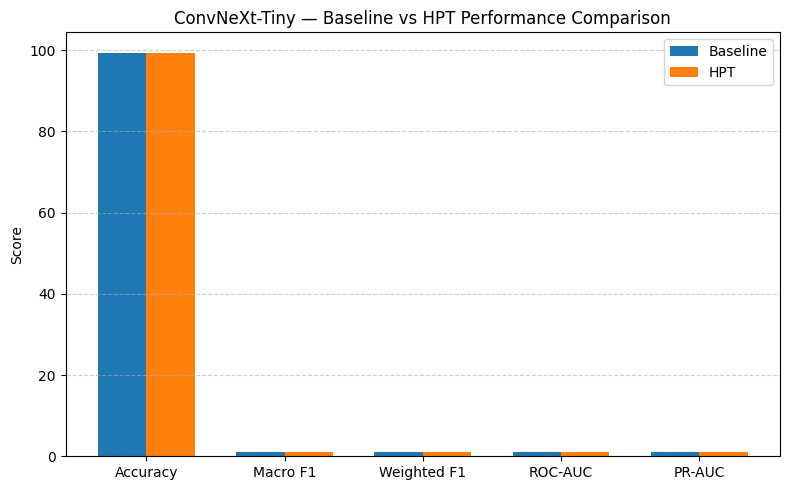

In [34]:
# =========================================================
# PHASE-4 — BASELINE vs HPT COMPARISON (ConvNeXt-Tiny)
# =========================================================

import pandas as pd
import matplotlib.pyplot as plt

# =======================
# Baseline metrics (from logs)
# =======================
baseline_test_acc    = 99.33
baseline_macro_f1    = 0.9933
baseline_weighted_f1 = 0.9933
baseline_roc_auc     = 0.9999
baseline_pr_auc      = 0.9994

# =======================
# HPT metrics (from logs)
# =======================
hpt_test_acc         = 99.44
hpt_macro_f1         = 0.9944
hpt_weighted_f1      = 0.9944
hpt_roc_auc          = 0.9999
hpt_pr_auc           = 0.9996

# =======================
# Summary Table
# =======================
summary = {
    "Metric": [
        "Test Accuracy (%)",
        "Macro F1 Score",
        "Weighted F1 Score",
        "Macro ROC-AUC",
        "Macro PR-AUC"
    ],
    "Baseline": [
        baseline_test_acc,


        baseline_macro_f1,
        baseline_weighted_f1,
        baseline_roc_auc,
        baseline_pr_auc
    ],
    "HPT": [
        hpt_test_acc,
        hpt_macro_f1,
        hpt_weighted_f1,
        hpt_roc_auc,
        hpt_pr_auc
    ],
    "Difference (HPT − Baseline)": [
        hpt_test_acc - baseline_test_acc,
        hpt_macro_f1 - baseline_macro_f1,
        hpt_weighted_f1 - baseline_weighted_f1,
        hpt_roc_auc - baseline_roc_auc,
        hpt_pr_auc - baseline_pr_auc
    ]
}

df_summary = pd.DataFrame(summary)
display(df_summary)

# =======================
# Bar Chart Comparison
# =======================
metrics = ["Accuracy", "Macro F1", "Weighted F1", "ROC-AUC", "PR-AUC"]

baseline_vals = [
    baseline_test_acc,
    baseline_macro_f1,
    baseline_weighted_f1,
    baseline_roc_auc,
    baseline_pr_auc
]

hpt_vals = [
    hpt_test_acc,
    hpt_macro_f1,
    hpt_weighted_f1,
    hpt_roc_auc,
    hpt_pr_auc
]

x = range(len(metrics))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x, baseline_vals, width, label="Baseline")
plt.bar([i + width for i in x], hpt_vals, width, label="HPT")

plt.xticks([i + width / 2 for i in x], metrics)
plt.ylabel("Score")
plt.title("ConvNeXt-Tiny — Baseline vs HPT Performance Comparison")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


